In [35]:
import cosmopower as cp
import frb_cov as frb
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as units
import numpy as np
from astropy.coordinates import Longitude, Latitude
import matplotlib.pyplot as plt
import pandas as pd
import time

bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")


In [36]:
file_paths = ['./../data/FRBCat_arXiv2307.03344.csv', './../data/FRBCat_arXiv2302.14788.csv', './../data/catalogue_updated.csv']
ra_labels = ['RA (FRB)', 'ra (deg)']
dec_labels = ['Dec (FRB)', 'dec (deg)']
redshift_labels = ['z (host)', 'redshift', 'z_gal']
DM_obs_labels = ['DM (pc/cm3)',"dm", 'DM_obs']
DM_MW_labels = ['DM_ISM',"dm_milky_way", 'DM_MW']

ra = []
dec = []
zet = []
DM_obs = []
DM_MW = []
frb_id = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    print(df.keys())
    for keys in ra_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                ra.append(i_aux)
        except:
            continue
    for keys in dec_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                dec.append(i_aux)
        except:
            continue
    for keys in DM_obs_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_obs.append(i_aux)
        except:
            continue
    for keys in redshift_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                zet.append(i_aux)
        except:
            continue
    for keys in DM_MW_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_MW.append(i_aux)
        except:
            continue
ra = np.array(ra)
dec = np.array(dec)
DM_obs = np.array(DM_obs)
DM_MW = np.array(DM_MW)
zet = np.array(zet)
ra = coord.Angle(ra, unit=units.degree)
dec = coord.Angle(dec, unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian


Index(['Unnamed: 0', 'FRB', 'Time', 'RA (FRB)', 'Dec (FRB)', 'S/N', 'Fluence',
       'DM (pc/cm3)', 'DMErr (pc/cm3)', 'DM_ISM (pc/cm3)', 'Width (ms)',
       'z (host)', 'M_r (host)', 'g-r (host)', 'log(M_*) (Msun) (host)',
       'SFR 100 Myr (Msun/yr) (host)', 't_m (Gyr) (host)',
       'L_PRS (erg/s/Hz) (host)', 'Host Name', 'RA (host)', 'Dec (host)',
       'm_r (mag) (host)', 'r_e (arcsec) (host)', 'Source', 'P_host'],
      dtype='object')
Index(['Unnamed: 0', 'FRB', 'RA (FRB)', 'Dec (FRB)', 'z_gal', 'DM_obs',
       'DM_MW', 'RM_obs', 'tau (ms)', 'F (Jy ms)', 'b (kpc)', 'z_gal (gal)',
       'RA (gal)', 'Dec (gal)', 'D_L [Mpc] (gal)', 'd [kpc] (gal)',
       'r_e [kpc] (gal)', 'log(M_star) [M_Sun] (gal)', 'SFR (gal)',
       'log(sSFR) [Gyr^-1] (gal)', 'log(z/z_Sun) (gal)', 'A_V (gal)',
       '$U_neb (gal)', 'u - r  (gal)', 'g - r (gal)', 'M_r (gal)',
       'Milky Way E(B - V) (gal)', 'RA (clust)', 'Dec (clust)', 'Richness',
       'z_clust', 'M_500 (M_Sun) (clust)', 'R_500 (

In [37]:
sigma8 = 0.834
h = 0.674
omegam = 0.3
omegab = 0.05
omegade = 1.0 - omegam
w0 = -1
wa = 0
ns = 0.963
neff = 3.046
mnu = 0
Tcmb0 = 2.725
alpha_B = 0.5
alpha_M = 0.5
log_TAGN = 7.8
ks = 1
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks]
cosmo = dict(zip(keys, values))
n_with_host = len(zet)
'''frb_cat = ascii.read("./../data/catalogue_updated.csv", data_start=1)
ra = coord.Angle(frb_cat["ra (deg)"], unit=units.degree)
dec = coord.Angle(frb_cat["dec (deg)"], unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian
counts = len(frb_cat["redshift"])

zet = frb_cat["redshift"][:n_with_host]
z = np.zeros(n_with_host)
DM_obs = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
    sep = '&'
    DM_obs[i] = frb_cat["dm"][i]
ra = ra[:n_with_host]
dec = dec[:n_with_host]
'''
z = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))



In [38]:

def gaussian_loglike(params):
    t0 = time.time()
    sigma_mw = 30.0
    sigma_host = 50.0
    DM_host = params['DM_host']
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,300)
    result = 0.0
    DM_mean = A*cov.DM + DM_host/(1.+z)
    cov_mat = A**2*cov.covariance + np.diag((sigma_host/(1.+z)))**2 + np.diag(sigma_mw*np.ones(len(z)))**2 
    precision_mat = np.linalg.inv(cov_mat)
    log_det_cov = np.linalg.slogdet(cov_mat)[1]
    delta = DM_obs - DM_mean
    quadraticform = np.einsum(
        'i,i', delta, np.einsum('ij,j', precision_mat, delta))
    result = -.5*(log_det_cov) - .5*quadraticform  
    print(time.time() - t0)
    return result



In [39]:
from scipy.stats import norm
from nautilus import Prior
from nautilus import Sampler

prior = Prior()
prior.add_parameter('alpha_B', dist=(0, 10))
prior.add_parameter('alpha_M', dist=(0, 10))
prior.add_parameter('A', dist=(0.5,10))
prior.add_parameter('DM_host', dist=(10,500))


sampler = Sampler(prior, gaussian_loglike, n_live=100, filepath='./../test/sampling_new.hdf5')


(array([6.92859354e-024, 3.63517413e-026, 4.35488241e-014, 4.71218246e-015,
        4.25761788e-011, 7.59668821e-009, 7.88265239e-008, 3.52447393e-007,
        2.78436132e-005, 1.05244775e-004, 2.46971611e-004, 1.96907937e-003,
        4.17672175e-003, 9.90892149e-003, 2.20636780e-002, 3.63227481e-002,
        5.09550907e-002, 7.67050230e-002, 9.31951173e-002, 1.03805099e-001,
        1.09015750e-001, 1.07833729e-001, 9.19650771e-002, 7.53745503e-002,
        6.56133690e-002, 4.51513826e-002, 3.68143834e-002, 2.62525344e-002,
        1.60738247e-002, 9.89207020e-003, 6.25617166e-003, 4.03775923e-003,
        2.20459603e-003, 1.96600644e-003, 9.60456329e-004, 4.15681085e-004,
        3.21424387e-004, 1.68104449e-004, 1.06165647e-004, 3.86334505e-005,
        2.75904379e-005, 9.31097191e-006, 7.09623810e-006, 3.22162521e-006,
        4.21845768e-006, 3.31698864e-007, 1.92529012e-006, 1.00256482e-006,
        1.76912893e-007, 1.36228584e-006, 8.99308573e-008, 3.50749603e-009,
        6.98

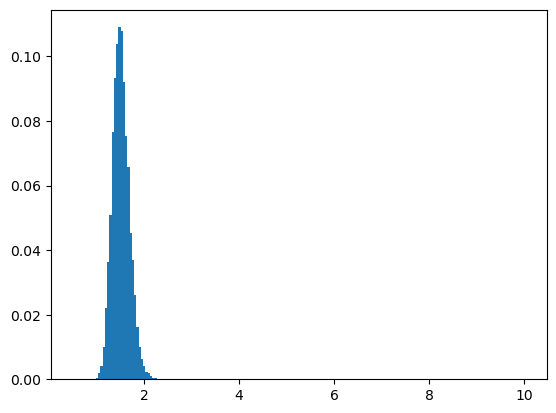

In [40]:
points, log_w, log_l = sampler.posterior()
plt.hist(points[:,2], bins = 200, weights=np.exp(log_w))